### Probably Overkill Imports

In [8]:
# Imports
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import pickle

# Import
# Math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
import random
from scipy.stats import norm
import scipy.optimize as optimize
import time
import math as m

# Ez parallelization
from joblib import Parallel, delayed

# File Handling
from sys import getsizeof
import _pickle as pickle
# Alternatively use JSON which will be human readable
# import json

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Custom imports
from MarketGeneratingFunctions.global_cache import Global_Cache
import MarketGeneratingFunctions.base_from_gen as bg
import MarketGeneratingFunctions.pricing_func as pf
from MarketGeneratingFunctions.path_datatype import Path

### Load a test dataset (In this case all runs with idx over 800 (where train maxes) :/)

In [9]:
## Load File
with open("1.6kRunDemo.pkl","rb") as fp:
    paths = pickle.load(fp)

paths = paths[1500:]

### Setup tests just like when testing delta hedge

#### Base Cases

In [10]:
### Unhedged PnL
def pnl_cva(path):
    pnl_without_hedge = np.zeros(len(path.CVA)-1)
    for i in range(1, len(path.CVA)):
        pnl_without_hedge[i-1] = path.CVA[i]-path.CVA[i-1]
    return pnl_without_hedge

pnl_without_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_without_hedge[i] = pnl_cva(paths[i])



### Delta Hedged PnL
if not 'T_s' in vars() or 'T_s' in globals():
    T_s = np.arange(0,11)
from MarketGeneratingFunctions import DeltaHedge
def DeltaFromFunc(path):
    pnl = np.zeros(len(path.CVA)-1)
    for i in range(len(path.CVA)-1):
        t = path.t_s[i]
        Q = [path.Q_s[j][i] for j in range(0,11)]
        Swapts = [path.Swaptions[j][i] for j in range(0,10)]
        T_sl = T_s.copy()
        
        [SwapsHedge,Qhedge] = DeltaHedge.delta_hedge(Swapts,Q,T_sl,t)

        cost = np.inner(SwapsHedge,Swapts) + np.inner(Qhedge,Q)
        
        futureSwapts = [path.Swaptions[j][i+1] for j in range(0,10)]
        futureQ = [path.Q_s[j][i+1] for j in range(0,11)]

        value = np.inner(SwapsHedge,futureSwapts) + np.inner(Qhedge,futureQ)

        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))
    return pnl

pnl_delta_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_delta_hedge[i] = DeltaFromFunc(paths[i])


#### RL Hedge

In [23]:
modelG = PPO.load("PPO")
modelR = PPO.load("dqn_lunar")

def rlHedge(path, model):
    pnl = np.zeros(len(path.CVA)-1)
    for i in range(round((len(path.CVA)-1)/10)):
        # Get State
        lambdax = path.lambdas[i]
        r = path.r[i]
        t = path.t_s[i]

        Q = [path.Q_s[j][i] for j in range(0,11)]
        Swapts = [path.Swaptions[j][i] for j in range(0,10)]

        futureSwapts = [path.Swaptions[j][i+1] for j in range(0,10)]
        futureQ = [path.Q_s[j][i+1] for j in range(0,11)]

        # Create Hedge
        hedgPos = model.predict(np.asarray([lambdax,r,t]))
        hedgPos = hedgPos[0]
        
        #print(hedgPos)

        # Split into swp and Q
        swpPos = hedgPos[0]
        QPos = hedgPos[1]

        # Test Hedge
        cost = Q[-1]*QPos + Swapts[-1]*swpPos
        #print(cost)
        value = futureQ[-1]*QPos + futureSwapts[-1]*swpPos
        #print(value)
        #print(value - cost)
        #print(path.CVA[i+1] - path.CVA[i]) 
        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))
    return pnl

pnl_RL_hedge = [None]*len(paths)
pnl_RL_hedgeb = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_RL_hedge[i] = rlHedge(paths[i], modelG)
    pnl_RL_hedgeb[i] = rlHedge(paths[i], modelR)            


(0.0, 1.0)

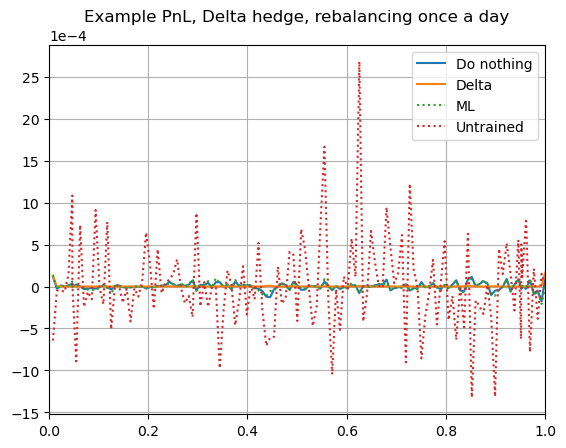

In [ ]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(paths[2].t_s[1:],pnl_without_hedge[2])
plt.plot(paths[2].t_s[1:],pnl_delta_hedge[2])
plt.plot(paths[2].t_s[1:],pnl_RL_hedge[2], linestyle = ':')
plt.plot(paths[2].t_s[1:],pnl_RL_hedgeb[2], linestyle = ':')
plt.legend(['Do nothing','Delta','Trained','Untrained'])
plt.xlim((0,1))